# Análise de Sentimento de E-Commerce: EDA + PNL

O objetivo deste caderno é propor uma visão analítica do relacionamento no comércio eletrônico no Brasil. Para isso, faremos uma análise exploratória de dados utilizando ferramentas gráficas para criar gráficos autoexplicativos e, assim, entender melhor o que está por trás das compras online no Brasil. Por fim, analisaremos as avaliações dos clientes e implementaremos a Análise Sentimental para realizar uma classificação textual utilizando ferramentas de Processo de Linguagem Natural.

Faremos uma longa jornada para compreender os dados e construir alguns gráficos úteis para esclarecer os conceitos e obter insights a partir dos dados. Por fim, apresentaremos um código passo a passo sobre a preparação de textos e a classificação de sentimentos utilizando as avaliações deixadas pelos clientes em plataformas online. Espero que gostem deste caderno!

Antes de começar a trabalhar, gostaria de agradecer a Raeshid David por compartilhar seu conteúdo e inspirar o estilo e a organização deste caderno.

In [1]:
!pip install geodatasets

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install geopandas

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Bibliotecas

In [3]:
# standard Libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
from PIL import Image
import re
import joblib
import os
from sklearn.pipeline import Pipeline
%matplotlib inline

In [4]:
import geopandas as gpd
import geodatasets

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## 2. Leitura dos Datasets

In [5]:
# Reading all the files
raw_path = '../data/data_original/'
olist_customer = pd.read_csv(raw_path + 'olist_customers_dataset.csv')
olist_geolocation = pd.read_csv(raw_path + 'olist_geolocation_dataset.csv')
olist_orders = pd.read_csv(raw_path + 'olist_orders_dataset.csv')
olist_order_items = pd.read_csv(raw_path + 'olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv(raw_path + 'olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv(raw_path + 'olist_order_reviews_dataset.csv')
olist_products = pd.read_csv(raw_path + 'olist_products_dataset.csv')
olist_sellers = pd.read_csv(raw_path + 'olist_sellers_dataset.csv')
product_category = pd.read_csv(raw_path + 'product_category_name_translation.csv')

## Visão Geral dos Dados

In [6]:
olist_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [7]:
olist_geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [8]:
## criar uma tabela com as informação dos datasets para ser usados posteriormente 


In [9]:

# caminho da pasta onde estão os CSVs
data_path = '../data/data_original/'

# dicionário com os nomes dos datasets e arquivos
files = {
    "olist_customer": "olist_customers_dataset.csv",
    "olist_geolocation": "olist_geolocation_dataset.csv",
    "olist_orders": "olist_orders_dataset.csv",
    "olist_order_items": "olist_order_items_dataset.csv",
    "olist_order_payments": "olist_order_payments_dataset.csv",
    "olist_order_reviews": "olist_order_reviews_dataset.csv",
    "olist_products": "olist_products_dataset.csv",
    "olist_sellers": "olist_sellers_dataset.csv",
    "product_category" : "product_category_name_translation.csv"
}

# lista para armazenar os resultados
results = []

for name, file in files.items():
    # ler dataset
    data = pd.read_csv(os.path.join(data_path, file))
    
    # número de linhas e colunas
    n_rows, n_cols = data.shape
    
    # total de valores nulos
    null_amount = data.isnull().sum().sum()
    
    # quantidade de colunas que possuem nulos
    qty_null_columns = (data.isnull().sum() > 0).sum()
    
    # lista das colunas que têm nulos
    null_columns = data.columns[data.isnull().any()].tolist()
    null_columns_str = ", ".join(null_columns) if null_columns else ""
    
    # adiciona no resultado
    results.append([
        name, n_rows, n_cols, null_amount, qty_null_columns, null_columns_str
    ])

# cria DataFrame final
summary_df = pd.DataFrame(
    results,
    columns=["dataset", "n_rows", "n_cols", "null_amount", "qty_null_columns", "null_columns"]
)

#print(summary_df)

# Se estiver no Jupyter ou Colab:
summary_df


,dataset,n_rows,n_cols,null_amount,qty_null_columns,null_columns
0,olist_customer,99441,5,0,0,
1,olist_geolocation,1000163,5,0,0,
2,olist_orders,99441,8,4908,3,"order_approved_at, order_delivered_carrier_dat..."
3,olist_order_items,112650,7,0,0,
4,olist_order_payments,103886,5,0,0,
5,olist_order_reviews,99224,7,145903,2,"review_comment_title, review_comment_message"
6,olist_products,32951,9,2448,8,"product_category_name, product_name_lenght, pr..."
7,olist_sellers,3095,4,0,0,
8,product_category,71,2,0,0,


In [10]:

# caminho da pasta onde estão os CSVs
data_path = '../data/data_original/'

# dicionário com os nomes dos datasets e arquivos
files = {
     "olist_customer": "olist_customers_dataset.csv",
    "olist_geolocation": "olist_geolocation_dataset.csv",
    "olist_orders": "olist_orders_dataset.csv",
    "olist_order_items": "olist_order_items_dataset.csv",
    "olist_order_payments": "olist_order_payments_dataset.csv",
    "olist_order_reviews": "olist_order_reviews_dataset.csv",
    "olist_products": "olist_products_dataset.csv",
    "olist_sellers": "olist_sellers_dataset.csv",
    "product_category" : "product_category_name_translation.csv" 
}

results = []

for dataset_name, file in files.items():
    data = pd.read_csv(os.path.join(data_path, file))
    n_rows = len(data)
    
    for col in data.columns:
        qtd_null = data[col].isnull().sum()
        percent_null = qtd_null / n_rows if n_rows > 0 else 0
        dtype = data[col].dtype
        
        # se for categórica (object), conta categorias únicas
        if dtype == "object":
            qtd_cat = data[col].nunique()
        else:
            qtd_cat = 0
        
        results.append([
            dataset_name,
            col,
            qtd_null,
            round(percent_null, 6),  # arredondado igual ao exemplo
            str(dtype),
            qtd_cat
        ])

# cria dataframe final
columns = ["dataset_name", "feature", "qtd_null", "percent_null", "dtype", "qtd_cat"]
summary_features_data= pd.DataFrame(results, columns=columns)

#print(summary_features_df)

# Se estiver no Jupyter/Colab:
summary_features_data


,dataset_name,feature,qtd_null,percent_null,dtype,qtd_cat
0,olist_customer,customer_id,0,0.000000,object,99441
1,olist_customer,customer_unique_id,0,0.000000,object,96096
2,olist_customer,customer_zip_code_prefix,0,0.000000,int64,0
3,olist_customer,customer_city,0,0.000000,object,4119
4,olist_customer,customer_state,0,0.000000,object,27
5,olist_geolocation,geolocation_zip_code_prefix,0,0.000000,int64,0
6,olist_geolocation,geolocation_lat,0,0.000000,float64,0
7,olist_geolocation,geolocation_lng,0,0.000000,float64,0
8,olist_geolocation,geolocation_city,0,0.000000,object,8011
9,olist_geolocation,geolocation_state,0,0.000000,object,27


## 3. Análise Exploratória de Dados

Agora, faremos uma análise exploratória de dados para obter insights sobre o comércio eletrônico no Brasil. O objetivo aqui é dividir esta sessão em tópicos para que possamos explorar gráficos para cada assunto (pedidos, clientes, produtos, itens e outros).

### 3.1. Análise dos clientes

In [11]:
olist_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [12]:
olist_customer.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [13]:
olist_geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


## 3.1.1 Perfil dos clientes

- Quem são (demografia/localização)

- Como compram (frequência, ticket médio, forma de pagamento)

- O que compram (categorias, mix de produtos)

- Se estão satisfeitos (reviews, feedback textual)

In [14]:
olist_customer.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [15]:
olist_geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [16]:
olist_customer['customer_city'].nunique()

4119

In [17]:
olist_customer['customer_state'].nunique()

27

In [18]:
olist_customer['customer_state'].unique()

array(['SP', 'SC', 'MG', 'PR', 'RJ', 'RS', 'PA', 'GO', 'ES', 'BA', 'MA',
       'MS', 'CE', 'DF', 'RN', 'PE', 'MT', 'AM', 'AP', 'AL', 'RO', 'PB',
       'TO', 'PI', 'AC', 'SE', 'RR'], dtype=object)

In [19]:
olist_geolocation['geolocation_city'].nunique()

8011

In [20]:
olist_geolocation['geolocation_state'].nunique()

27

In [21]:
# acrescentado o nome do estado e regiao do pais
state_region = {
    'AC': ('Acre', 'Norte'),
    'AL': ('Alagoas', 'Nordeste'),
    'AP': ('Amapá', 'Norte'),
    'AM': ('Amazonas', 'Norte'),
    'BA': ('Bahia', 'Nordeste'),
    'CE': ('Ceará', 'Nordeste'),
    'DF': ('Distrito Federal', 'Centro-Oeste'),
    'ES': ('Espírito Santo', 'Sudeste'),
    'GO': ('Goiás', 'Centro-Oeste'),
    'MA': ('Maranhão', 'Nordeste'),
    'MT': ('Mato Grosso', 'Centro-Oeste'),
    'MS': ('Mato Grosso do Sul', 'Centro-Oeste'),
    'MG': ('Minas Gerais', 'Sudeste'),
    'PA': ('Pará', 'Norte'),
    'PB': ('Paraíba', 'Nordeste'),
    'PR': ('Paraná', 'Sul'),
    'PE': ('Pernambuco', 'Nordeste'),
    'PI': ('Piauí', 'Nordeste'),
    'RJ': ('Rio de Janeiro', 'Sudeste'),
    'RN': ('Rio Grande do Norte', 'Nordeste'),
    'RS': ('Rio Grande do Sul', 'Sul'),
    'RO': ('Rondônia', 'Norte'),
    'RR': ('Roraima', 'Norte'),
    'SC': ('Santa Catarina', 'Sul'),
    'SP': ('São Paulo', 'Sudeste'),
    'SE': ('Sergipe', 'Nordeste'),
    'TO': ('Tocantins', 'Norte')
}

# criando novas colunas 
olist_customer['state_region'] = olist_customer['customer_state'].map(lambda x: state_region[x][0])
olist_customer['region'] = olist_customer['customer_state'].map(lambda x: state_region[x][1])

olist_customer.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,state_region,region
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,São Paulo,Sudeste
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,São Paulo,Sudeste
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,São Paulo,Sudeste
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,São Paulo,Sudeste
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,São Paulo,Sudeste


## 3.1.2 Distribuição dos clientes por estados (UF)

In [22]:
# CONTAGEM DE CLIENTES POR ESTADOS

customer_state = olist_customer['customer_state'].value_counts().reset_index()
customer_state.columns = ['state', 'qtd_customer']

In [23]:
customer_state.head(10)

,state,qtd_customer
0,SP,41746
1,RJ,12852
2,MG,11635
3,RS,5466
4,PR,5045
5,SC,3637
6,BA,3380
7,DF,2140
8,ES,2033
9,GO,2020


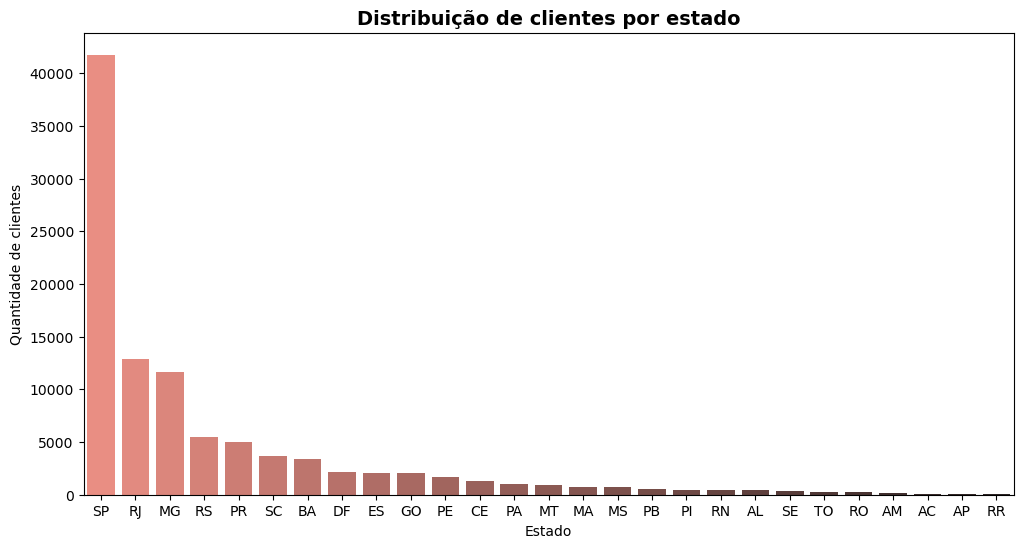

In [24]:
plt.figure(figsize=(12,6))
sns.barplot(x='state', y='qtd_customer', data=customer_state, palette='dark:salmon_r')
plt.title('Distribuição de clientes por estado', fontsize=14, weight='bold')
plt.xlabel("Estado")
plt.ylabel("Quantidade de clientes")
plt.show()

## 3.1.3 Distribuição dos clientes por região

In [25]:
# CONTAGEM DE CLIENTES POR REGIAO

customer_region = olist_customer['region'].value_counts().reset_index()
customer_region.columns = ['region', 'qtd_customer']
customer_region

,region,qtd_customer
0,Sudeste,68266
1,Sul,14148
2,Nordeste,9394
3,Centro-Oeste,5782
4,Norte,1851


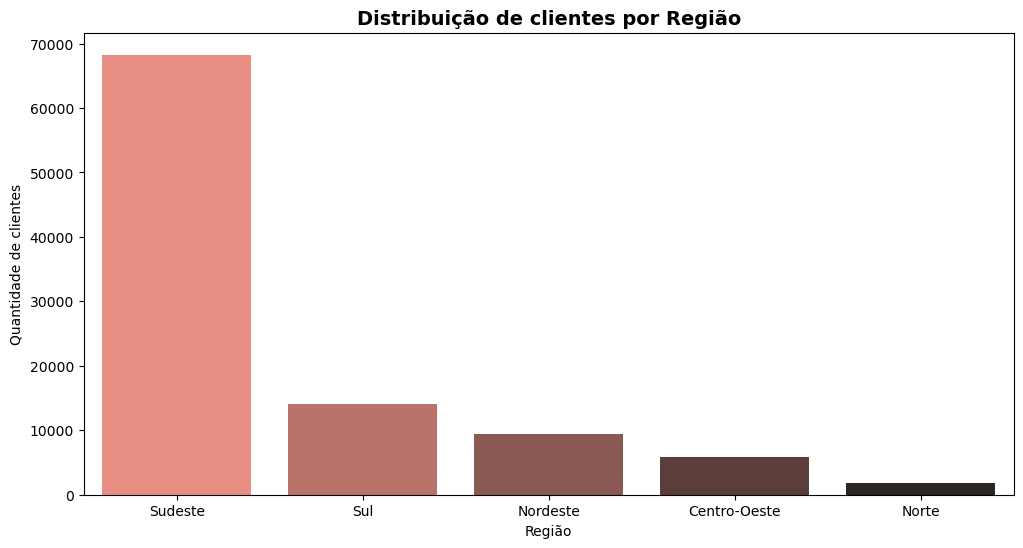

In [26]:
plt.figure(figsize=(12,6))
sns.barplot(x='region', y='qtd_customer', data=customer_region, palette='dark:salmon_r')
plt.title('Distribuição de clientes por Região', fontsize=14, weight='bold')
plt.xlabel("Região")
plt.ylabel("Quantidade de clientes")
plt.show()

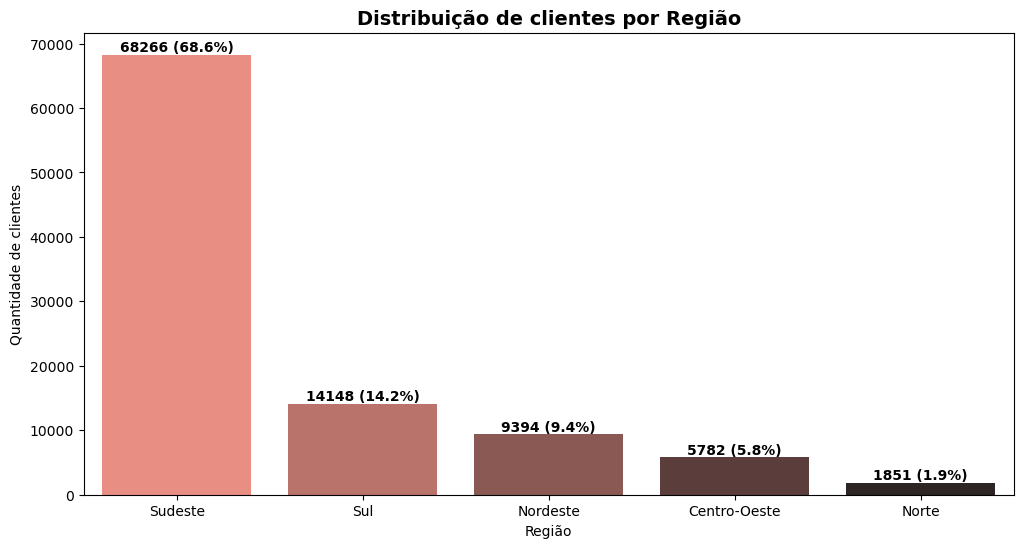

In [27]:
plt.figure(figsize=(12,6))
sns.barplot(x='region', y='qtd_customer', data=customer_region, palette='dark:salmon_r')

plt.title('Distribuição de clientes por Região', fontsize=14, weight='bold')
plt.xlabel("Região")
plt.ylabel("Quantidade de clientes")

# total de clientes
overall_customer = customer_region["qtd_customer"].sum()

# adicionar quantidade + porcentagem em cada barra
for index, value in enumerate(customer_region["qtd_customer"]):
    perc = (value / overall_customer) * 100
    plt.text(index, value + 0.5, f"{value} ({perc:.1f}%)", 
             ha='center', va='bottom', fontsize=10, weight="bold")

plt.show()

## 3.1.3 Top 10 cidades com mais clientes

In [28]:
customer_city = olist_customer['customer_city'].value_counts().head(20).reset_index()
customer_city.columns = ['city','qtd_customer']

In [29]:
customer_city.head(20)

,city,qtd_customer
0,sao paulo,15540
1,rio de janeiro,6882
2,belo horizonte,2773
3,brasilia,2131
4,curitiba,1521
5,campinas,1444
6,porto alegre,1379
7,salvador,1245
8,guarulhos,1189
9,sao bernardo do campo,938


In [30]:
# renomear e padronizar as cidade com a primeira letra maiuscula
olist_customer['customer_city'] = olist_customer['customer_city'].str.title()
olist_customer.tail(20)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,state_region,region
99421,5eef6cce1f34954c9e7004332388ccc7,5a1680640123fc80e801301a2fb57395,11045,Santos,SP,São Paulo,Sudeste
99422,821a7275a08f32975caceff2e08ea262,046470763123d3d6364f89095b4e47ab,5734,Sao Paulo,SP,São Paulo,Sudeste
99423,c6ece8a5137f3c9c3a3a12302a19a2ac,aaf22868003377e859049dcf5f0b3fdf,1323,Sao Paulo,SP,São Paulo,Sudeste
99424,e5ed7280cd1a3ac2ba29fd6650d8867c,206e64e8af2633a2ebe158a7fcb860db,8560,Poa,SP,São Paulo,Sudeste
99425,0a7db3996b88954c7aa763b5dd621d5b,15637b62dfa4c5a9df846b22beef0994,52090,Recife,PE,Pernambuco,Nordeste
99426,935993f47af1ed7d0715c26b686341c5,4452b8ef472646c4cc042cb31a291f3b,12236,Sao Jose Dos Campos,SP,São Paulo,Sudeste
99427,592b8900e0e8325027d885e6d30d0283,57c2cfb4a80b13ed19b5fb258d29c19d,15720,Palmeira D'Oeste,SP,São Paulo,Sudeste
99428,ffa6d90c36a9c7004692ca50761c69d6,874c93d867b18eb09a5e2f071ee89458,13140,Paulinia,SP,São Paulo,Sudeste
99429,1ed0c832c2dd99570a59260e71768bdf,82d46759af0369aad49084bacf85a6c3,37610,Bom Repouso,MG,Minas Gerais,Sudeste
99430,27b9b32173455ef32167540451749d0b,277490f0d435b602fe4475d4b89e9181,6727,Cotia,SP,São Paulo,Sudeste


In [31]:
# corrigir algumas nome de cidades a sua acentuação
corrections = {
    "Sao Paulo": "São Paulo",
    "Sao Bernardo Do Campo": "São Bernardo do Campo",
    "Mogi Das Cruzes": "Mogi das Cruzes",
    "Jaragua Do Sul": "Jaraguá do Sul",
    "Timoteo": "Timóteo",
    "Rio De Janeiro":"Rio de Janeiro",
    "Pacaja": "Pacajá",
    "Lençóis Paulista": "Lençóis Paulista",
    "Caxias Do Sul":"Caxias do Sul",
    "Poa": "Poá",
    "Sao Jose Dos Campos":"São José dos Campos",
    "Palmeira D'Oeste": "Palmeira d'Oeste",
    "Paulinia": "Paulínia",
    "Belem": "Belém",
    "Brasilia": "Brasília",
    "Divinopolis": "Divinópolis", 
    "Taboao Da Serra":"Taboão da Serra",
    "Poa": "Poá",
    "Niteroi": "Niterói",
    "Santo Andre": "Santo André",
    "Goiania":"Goiânia",
    "Florianopolis":"Florianópolis"
}

olist_customer['customer_city'] = olist_customer['customer_city'].replace(corrections)

olist_customer.head(10)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,state_region,region
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,Franca,SP,São Paulo,Sudeste
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,São Bernardo do Campo,SP,São Paulo,Sudeste
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,São Paulo,SP,São Paulo,Sudeste
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,Mogi das Cruzes,SP,São Paulo,Sudeste
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,Campinas,SP,São Paulo,Sudeste
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,Jaraguá do Sul,SC,Santa Catarina,Sul
6,fd826e7cf63160e536e0908c76c3f441,addec96d2e059c80c30fe6871d30d177,4534,São Paulo,SP,São Paulo,Sudeste
7,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,35182,Timóteo,MG,Minas Gerais,Sudeste
8,5adf08e34b2e993982a47070956c5c65,1175e95fb47ddff9de6b2b06188f7e0d,81560,Curitiba,PR,Paraná,Sul
9,4b7139f34592b3a31687243a302fa75b,9afe194fb833f79e300e37e580171f22,30575,Belo Horizonte,MG,Minas Gerais,Sudeste


In [32]:
customer_city = olist_customer['customer_city'].value_counts().head(10).reset_index()
customer_city.columns = ['city','qtd_customer']

In [33]:
customer_city

,city,qtd_customer
0,São Paulo,15540
1,Rio de Janeiro,6882
2,Belo Horizonte,2773
3,Brasília,2131
4,Curitiba,1521
5,Campinas,1444
6,Porto Alegre,1379
7,Salvador,1245
8,Guarulhos,1189
9,São Bernardo do Campo,938


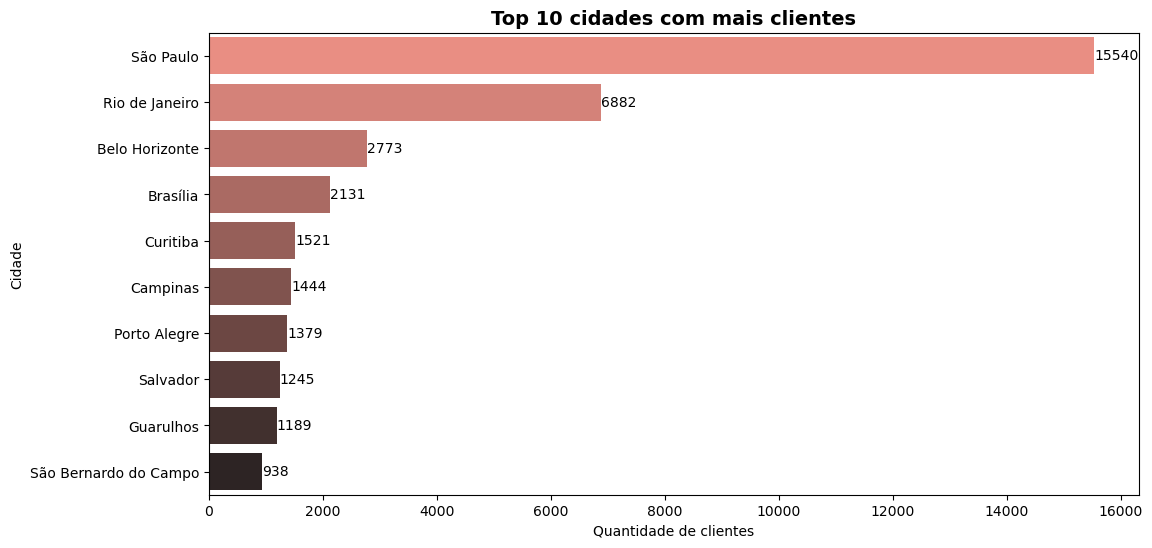

In [34]:
plt.figure(figsize=(12,6))
sns.barplot(y="city", x="qtd_customer", data=customer_city, palette="dark:salmon_r")
plt.title("Top 10 cidades com mais clientes", fontsize=14, weight="bold")
plt.xlabel("Quantidade de clientes")
plt.ylabel("Cidade")

# Adicionar os valores em cada barra
for index, value in enumerate(customer_city["qtd_customer"]):
    plt.text(value + 0.5, index, str(value), va="center", fontsize=10)
plt.show()

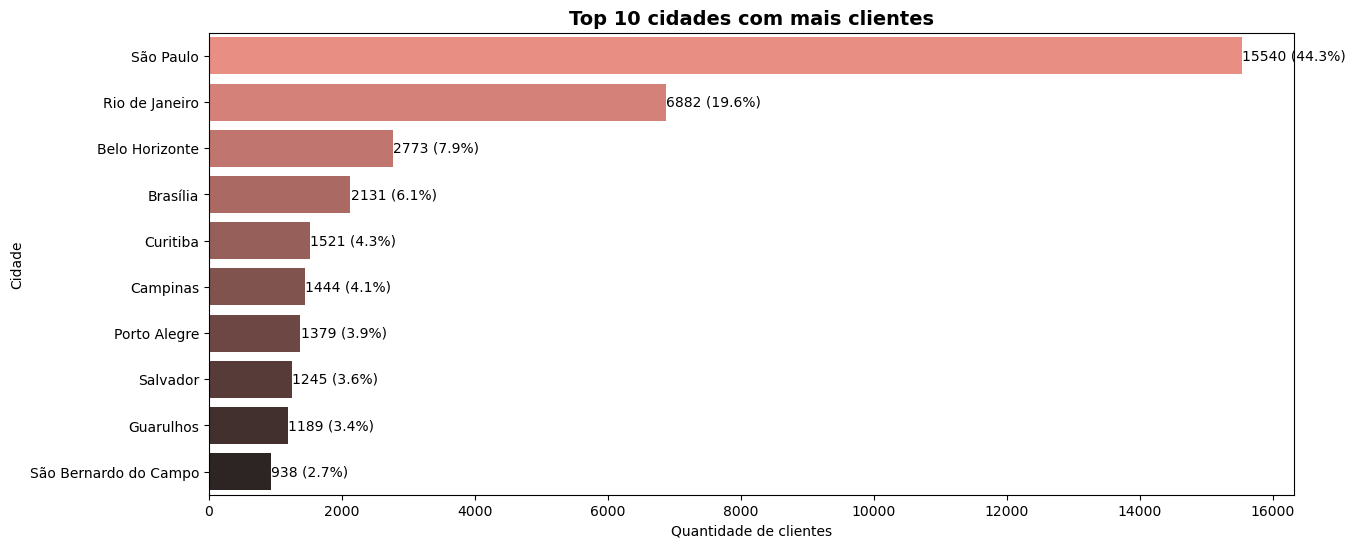

In [35]:
plt.figure(figsize=(14,6))
sns.barplot(y="city", x="qtd_customer", data=customer_city, palette="dark:salmon_r")
plt.title("Top 10 cidades com mais clientes", fontsize=14, weight="bold")
plt.xlabel("Quantidade de clientes")
plt.ylabel("Cidade")

# total de clientes
overall_customer = customer_city["qtd_customer"].sum()

# adicionar quantidade + porcentagem em cada barra
for index, value in enumerate(customer_city["qtd_customer"]):
    perc = (value / overall_customer) * 100
    plt.text(value + 0.5, index, f"{value} ({perc:.1f}%)", va="center", fontsize=10)

plt.show()

## 3.1.3 Mapa de calor (usando latitude/longitude)

In [36]:
# unir os datasets pelo prefixo do cep

customers = olist_customer
geolocation = olist_geolocation

In [37]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,state_region,region
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,Franca,SP,São Paulo,Sudeste
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,São Bernardo do Campo,SP,São Paulo,Sudeste
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,São Paulo,SP,São Paulo,Sudeste
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,Mogi das Cruzes,SP,São Paulo,Sudeste
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,Campinas,SP,São Paulo,Sudeste


In [38]:
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [39]:
# juntar os dois datasets
customers_geo = customers.merge(geolocation, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
customers_geo.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,state_region,region,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,Franca,SP,São Paulo,Sudeste,14409.0,-20.509897,-47.397866,franca,SP
1,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,Franca,SP,São Paulo,Sudeste,14409.0,-20.497396,-47.399241,franca,SP
2,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,Franca,SP,São Paulo,Sudeste,14409.0,-20.510459,-47.399553,franca,SP
3,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,Franca,SP,São Paulo,Sudeste,14409.0,-20.480940,-47.394161,franca,SP
4,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,Franca,SP,São Paulo,Sudeste,14409.0,-20.515413,-47.398194,franca,SP


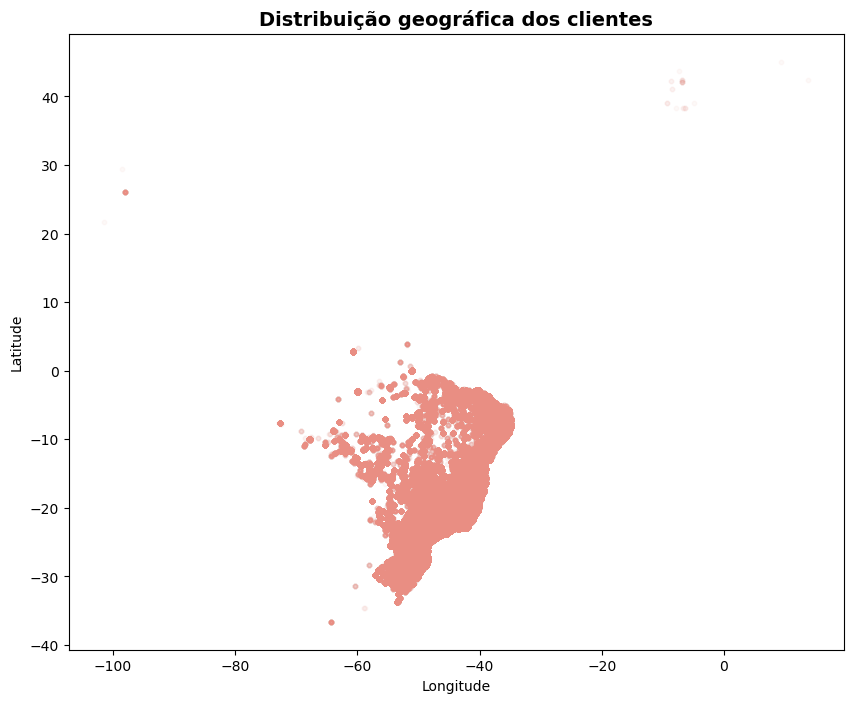

In [40]:
# Plotando um scatterplot simplificado do Brasil
plt.figure(figsize=(10,8))
plt.scatter(
    customers_geo["geolocation_lng"],
    customers_geo["geolocation_lat"],
    alpha=0.05, s=10, c="#e98e83"
)
plt.title("Distribuição geográfica dos clientes", fontsize=14, weight="bold")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

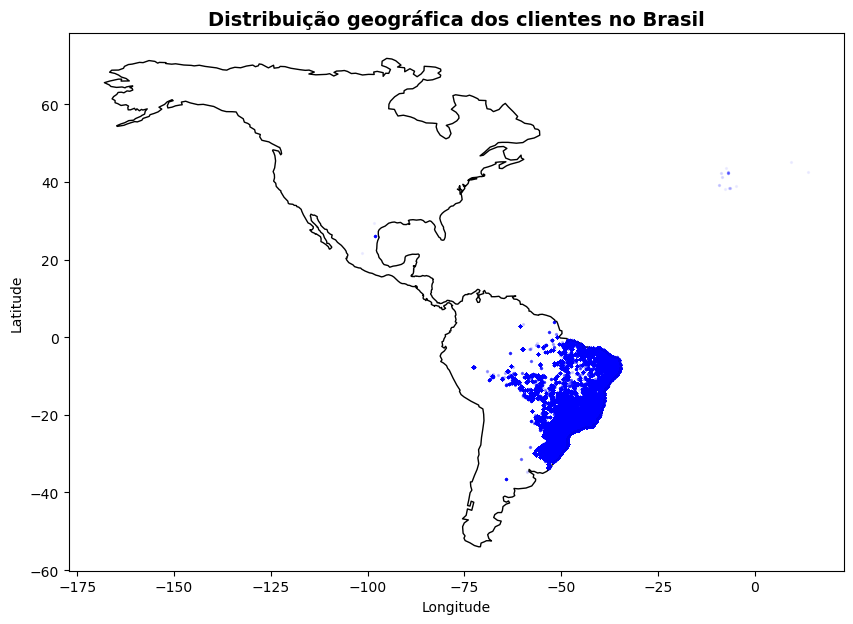

In [41]:
# carregar shapefile simplificado (mundo)
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

# filtrar apenas o Brasil
brasil = world.cx[-74:-34, -34:6]  # limites aproximados do Brasil

# converter os clientes em GeoDataFrame
gdf_customers = gpd.GeoDataFrame(
    customers_geo,
    geometry=gpd.points_from_xy(customers_geo["geolocation_lng"], customers_geo["geolocation_lat"]),
    crs="EPSG:4326"
)

# plot
fig, ax = plt.subplots(figsize=(10,8))
brasil.plot(ax=ax, color="white", edgecolor="black")
gdf_customers.plot(ax=ax, markersize=2, alpha=0.05, color="blue")

plt.title("Distribuição geográfica dos clientes no Brasil", fontsize=14, weight="bold")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
